#Initialization

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rnd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pickle
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Arcface/backbone_0.py .
!cp /content/drive/MyDrive/Arcface/hypar.py .
!cp /content/drive/MyDrive/Arcface/network_16.py .
import hypar
import backbone_0 as nn
import network_16 as net

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##GPU Connect

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Helper Functions

In [ ]:
def get_embeddings(input_imgs,model):
  test_model = model.resnet
  embeddings = test_model.predict(input_imgs)
  print(embeddings.shape)
  return embeddings

In [ ]:
def get_distance(emb1,emb2):
  """
  emb1 & emb2: are both 512 dimensional vectors from the trained resnet model

  get_distance: returns dot_prod,cosine_distance,euclidean_distance
  Check Out "https://github.com/zestyoreo/Arcface/blob/main/get_distance()_test.ipynb" for clarity
  """
  dot_prod = np.dot(emb1,emb2.T)

  a = np.matmul(np.transpose(emb1), emb2)
  b = np.sum(np.multiply(emb1, emb1))
  c = np.sum(np.multiply(emb2, emb2))
  cosine_distance = 1 - (a / (np.sqrt(b) * np.sqrt(c)))

  euclidean_distance = emb1 - emb2
  euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
  euclidean_distance = np.sqrt(euclidean_distance)

  return dot_prod,cosine_distance,euclidean_distance

In [ ]:
def calculate_threshold(X,Y,model,nor,epochs):
  index = [None] * X.shape[0]

  #getting and storing embeddings
  embeddings = get_embeddings(X,model)
  file_name = "/content/drive/MyDrive/Arcface/train_data_embeddings_"+str(epochs)+"model.npy"
  if nor==True:
    embeddings = normalize(embeddings, axis = 0)
    file_name = "/content/drive/MyDrive/Arcface/train_data_normalized_embeddings_"+str(epochs)+"model.npy"
  emb = np.array(embeddings)
  np.save(file_name,emb)

  same_person_distance = []
  same_person_cosine_distance = []
  same_person_euclidean_distance = []
  for clas in range(hypar.num_classes):
    index[clas] = []
    for i in range (0,X.shape[0]):
      if Y[i] == clas:
        index[clas].append(i)
    for i in range(len(index[clas])):
      i1=index[clas][i]
      for j in range(i+1,len(index[clas])):
        j2=index[clas][j]
        distance,cosine_distance,euclidean_distance = get_distance(embeddings[i1],embeddings[j2])
        same_person_distance.append(distance)
        same_person_cosine_distance.append(cosine_distance)
        same_person_euclidean_distance.append(euclidean_distance)

  same_person_distance = np.asarray(same_person_distance)
  same_person_cosine_distance = np.asarray(same_person_cosine_distance)
  same_person_euclidean_distance = np.asarray(same_person_euclidean_distance)

  #saving same person distances
  f1 = "/content/drive/MyDrive/Arcface/same_person_distance_"+str(epochs)+"model.npy"
  f2 = "/content/drive/MyDrive/Arcface/same_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "/content/drive/MyDrive/Arcface/same_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "/content/drive/MyDrive/Arcface/same_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "/content/drive/MyDrive/Arcface/same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "/content/drive/MyDrive/Arcface/same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,same_person_distance)
  np.save(f2,same_person_cosine_distance)
  np.save(f3,same_person_euclidean_distance)
  
  same_person_distance_mean = np.mean(same_person_distance)
  same_person_cosine_distance_mean = np.mean(same_person_cosine_distance)
  same_person_euclidean_distance_mean = np.mean(same_person_euclidean_distance)

  diff_person_distance = []
  diff_person_cosine_distance = []
  diff_person_euclidean_distance = []
  for clas in range(hypar.num_classes):
      for c in range(clas+1,hypar.num_classes):
          for i in range(len(index[clas])):
              for j in range(len(index[c])):
                  distance,cosine_distance,euclidean_distance = get_distance(embeddings[index[clas][i]],embeddings[index[c][j]])
                  diff_person_distance.append(distance)
                  diff_person_cosine_distance.append(cosine_distance)

                  diff_person_euclidean_distance.append(euclidean_distance)

  diff_person_distance = np.asarray(diff_person_distance)
  diff_person_cosine_distance = np.asarray(diff_person_cosine_distance)
  diff_person_euclidean_distance = np.asarray(diff_person_euclidean_distance)

  #saving different person distances
  f1 = "/content/drive/MyDrive/Arcface/diff_person_distance_"+str(epochs)+"model.npy"
  f2 = "/content/drive/MyDrive/Arcface/diff_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "/content/drive/MyDrive/Arcface/diff_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "/content/drive/MyDrive/Arcface/diff_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "/content/drive/MyDrive/Arcface/diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "/content/drive/MyDrive/Arcface/diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,diff_person_distance)
  np.save(f2,diff_person_cosine_distance)
  np.save(f3,diff_person_euclidean_distance)

  diff_person_distance_mean = np.mean(diff_person_distance)
  diff_person_cosine_distance_mean = np.mean(diff_person_cosine_distance)
  diff_person_euclidean_distance_mean = np.mean(diff_person_euclidean_distance)

  alpha=0.8
  distance_threshold = diff_person_distance_mean*(1-alpha)+same_person_distance_mean*alpha
  cosine_distance_threshold = diff_person_cosine_distance_mean*(1-alpha)+same_person_cosine_distance_mean*alpha
  euclidean_distance_threshold = diff_person_euclidean_distance_mean*(1-alpha)+same_person_euclidean_distance_mean*alpha
  return distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean

In [ ]:
def recognise(img,face_imgs_database,face_embedding_database,face_names_database):
  """
  img: numpy array of dims (112,112,3) of image of face to be recognised
  face_imgs_database: numpy array of dims (num_of_faces,512)
  face_names_database: dictionary of form {index_of_face:"name_of_person"} comprising of names of faces in face_imgs_database array
    
  recognise: returns the name and face of the closest match in the database
  """
  img_embedding = get_embeddings(img)
  best_match_index = []
  best_distance = float('-inf')
  for i in range(int(face_embedding_database.shape[0])):
    distance,cosine_distance,euclidean_distance = get_distance(img_embedding,face_embedding_database[i])
    if distance>best_distance:
      best_distance = distance
      best_match_index = [i]
    elif distance==best_distance:
      best_match_index.append(i)

  names = []
  faces = []
  for i in best_match_index:
    names.append(face_names_database[i])
    aces.append(face_imgs_database[i])
    
  return names,faces

In [ ]:
def verify(img,face):
  """
  img: numpy array of dims (112,112,3) of image of face to be verified
  face: image of face of person to be verified with
    
  verify: returns boolean if the faces match or not
  """
  img_embedding = get_embeddings(img)
  face_embedding = get_embeddings(face)
  distance,cosine_distance,euclidean_distance = get_distance(img_embedding,face_embedding)
  if distance>threshold:
    return True
  return False

#Loss Plot

In [ ]:
loss_log = np.load('/content/drive/MyDrive/Arcface/checkpoint/try3/loss_log/loss_log_1.npy')
for i in range(2,4):
  f = "/content/drive/MyDrive/Arcface/checkpoint/try3/loss_log/loss_log_"+str(i)+".npy"
  x = np.load(f)
  loss_log = np.concatenate((loss_log,x))
print(loss_log.shape)

skip = 10
plt.plot(list(range(1,275+1)),loss_log[::skip])
plt.title("Loss Plot")
plt.xlabel("Steps/200")
plt.ylabel("Loss")
plt.show()

#Importing Train data

In [ ]:
X = np.load('/content/drive/MyDrive/Arcface/x_train.npy', allow_pickle=True)
Y = np.load('/content/drive/MyDrive/Arcface/y_train.npy', allow_pickle=True)
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='int32')
Y = np.reshape(Y, Y.shape[0])
print("X shape:",X.shape,"Y shape:",Y.shape)
X = net.Resnet_preprocess(X)
print("Training data ready!")

X shape: (1476, 112, 112, 3) Y shape: (1476,)
Training data ready!


In [ ]:
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


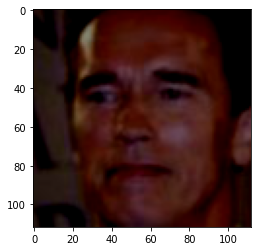

In [ ]:
index = 139
photo = cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB)
plt.imshow(photo/255)
plt.show()

#Distance Plots

In [ ]:
d_threshold= []
cd_threshold = []
ed_threshold = []
d_norm_threshold= []
cd_norm_threshold = []
ed_norm_threshold = []
for file_number in [800]:
  #loading model
  file_name = '/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_'
  file_name = file_name + str(file_number)+ '_epochs'
  print(file_name)
  model = tf.keras.models.load_model(file_name)

  #non-normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = calculate_threshold(X,Y,model,False,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_threshold.append(distance_threshold)
  cd_threshold.append(cosine_distance_threshold)
  ed_threshold.append(euclidean_distance_threshold)

  #normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = calculate_threshold(X,Y,model,True,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_norm_threshold.append(distance_threshold)
  cd_norm_threshold.append(cosine_distance_threshold)
  ed_norm_threshold.append(euclidean_distance_threshold)

In [ ]:
file_name = '/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_'
file_name = file_name + str(800)+ '_epochs'
print(file_name)
model = tf.keras.models.load_model(file_name)

/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_800_epochs


In [ ]:
model.summary()

Model: "train_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 512)               40630144  
_________________________________________________________________
arcface__layer_1 (Arcface_La multiple                  167424    
Total params: 40,797,568
Trainable params: 40,743,424
Non-trainable params: 54,144
_________________________________________________________________


In [ ]:
test_model = model.resnet

In [ ]:
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
Total params: 40,630,144
Trainable params: 40,576,000
Non-trainable params: 54,144
_________________________________________________________________


In [ ]:
test_model.save_weights('/content/drive/MyDrive/Arcface/checkpoint/mb_download'+ '.h5')

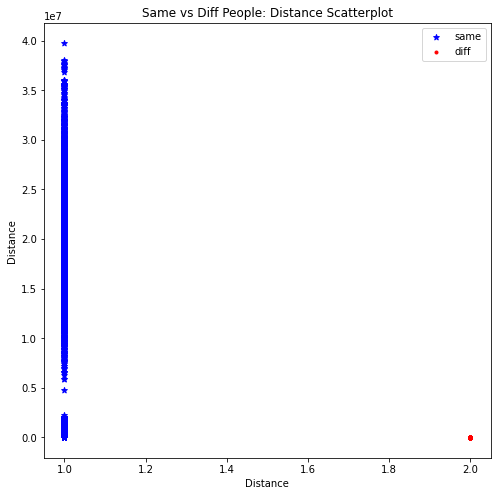

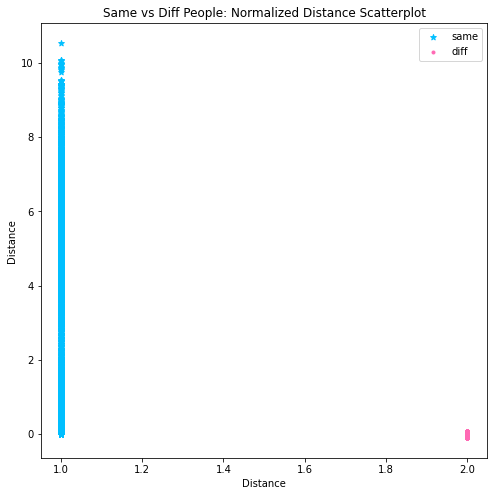

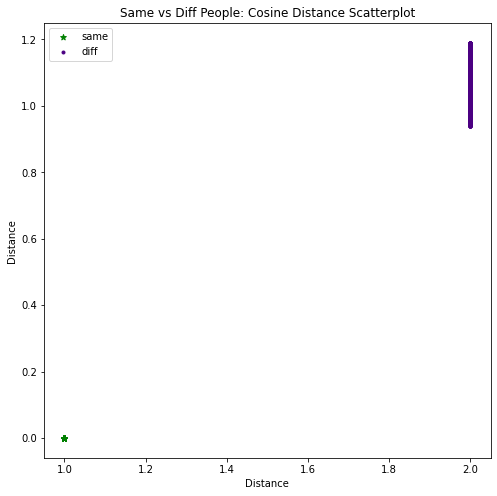

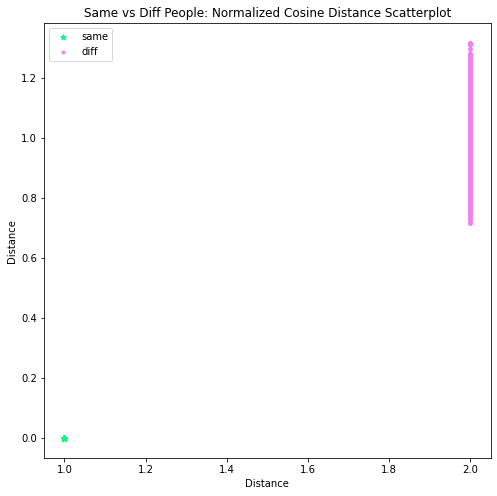

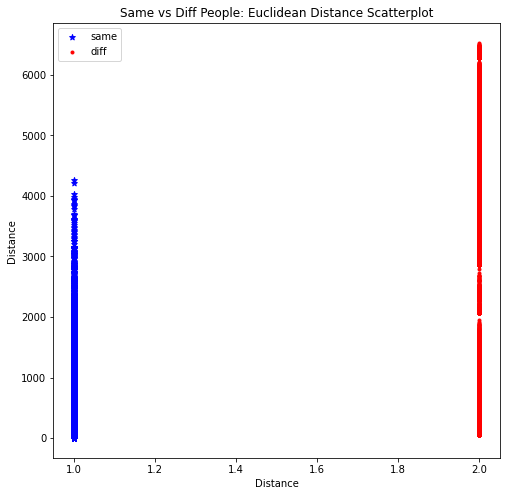

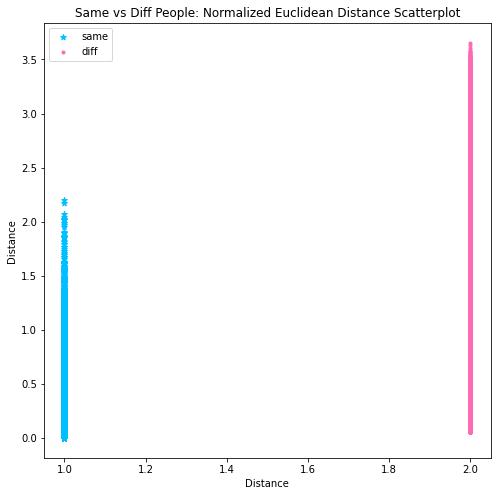

In [ ]:
epochs = 800

#loading data
f1 = "/content/drive/MyDrive/Arcface/same_person_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/same_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/same_person_euclidean_distance_"+str(epochs)+"model.npy"

same_person_distance = np.load(f1)
same_person_cosine_distance = np.load(f2)
same_person_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/same_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

same_person_norm_distance = np.load(f1)
same_person_norm_cosine_distance = np.load(f2)
same_person_norm_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/diff_person_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/diff_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/diff_person_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_distance = np.load(f1)
diff_person_cosine_distance = np.load(f2)
diff_person_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/diff_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_norm_distance = np.load(f1)
diff_person_norm_cosine_distance = np.load(f2)
diff_person_norm_euclidean_distance = np.load(f3)

#_____Creating scatter plots (same vs diff)_______
def scatter_plot(same,diff,title,color1,color2):
  plt.figure(figsize = (8,8))
  al = np.ones((len(same)))
  al2 = np.ones((len(diff)))
  plt.scatter(al, same, color=color1, marker="*")
  plt.scatter(2*al2, diff, color=color2, marker=".")
  plt.xlabel("Distance")
  plt.ylabel("Distance")
  plt.legend(["same","diff"])
  plt.title(title)
  plt.show()

#distance data
scatter_plot(same_person_distance, diff_person_distance, "Same vs Diff People: Distance Scatterplot", "blue", "red")

#normailzed distance data
scatter_plot(same_person_norm_distance,diff_person_norm_distance,"Same vs Diff People: Normalized Distance Scatterplot", "deepskyblue", "hotpink")

#cosine distance data
scatter_plot(same_person_cosine_distance, diff_person_cosine_distance, "Same vs Diff People: Cosine Distance Scatterplot", "green", "indigo")

#cosine normailzed distance data
scatter_plot(same_person_norm_cosine_distance, diff_person_norm_cosine_distance, "Same vs Diff People: Normalized Cosine Distance Scatterplot", "springgreen", "violet")

#euclidean distance data
scatter_plot(same_person_euclidean_distance, diff_person_euclidean_distance, "Same vs Diff People: Euclidean Distance Scatterplot", "blue", "red")

#euclidean normailzed distance data
scatter_plot(same_person_norm_euclidean_distance, diff_person_norm_euclidean_distance, "Same vs Diff People: Normalized Euclidean Distance Scatterplot", "deepskyblue", "hotpink")

#Analysis

In [ ]:
print(diff_person_norm_cosine_distance.shape)
acc = np.sum(diff_person_norm_cosine_distance < 0.15)
print(acc)
print(float(acc)/diff_person_norm_cosine_distance.shape[0])

(1079407,)
0
0.0


#Threshold Plots

In [ ]:
epoch = [300,700,800]

#distance threshold
plt.plot(epoch,d_threshold,color="blue")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Distance Threshold")
plt.show()

#distance normalized threshold
plt.plot(epoch,d_threshold,color="deepskyblue")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Distance Normalized Threshold")
plt.show()

#cosine distance threshold
plt.plot(epoch,cd_threshold,color="red")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Cosine Distance Threshold")
plt.show()

#cosine distance normalized threshold
plt.plot(epoch,cd_threshold,color="hotpink")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Cosine Distance Normalized Threshold")
plt.show()

#euclidean distance threshold
plt.plot(epoch,ed_threshold,color="green")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Euclidean Distance Threshold")
plt.show()

#euclidean distance normalized threshold
plt.plot(epoch,ed_threshold,color="springgreen")
plt.xlabel("Epochs")
plt.ylabel("Threshold")
plt.title("Euclidean Distance Normalized Threshold")
plt.show()



#Embedding PCA Plots

(1, 512) (1, 512)
(38, 512) (38, 512)


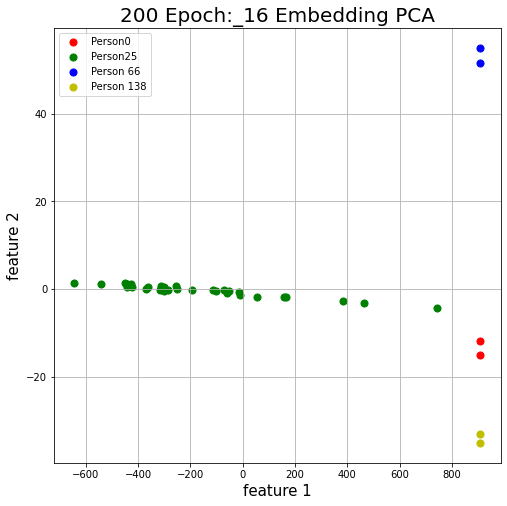

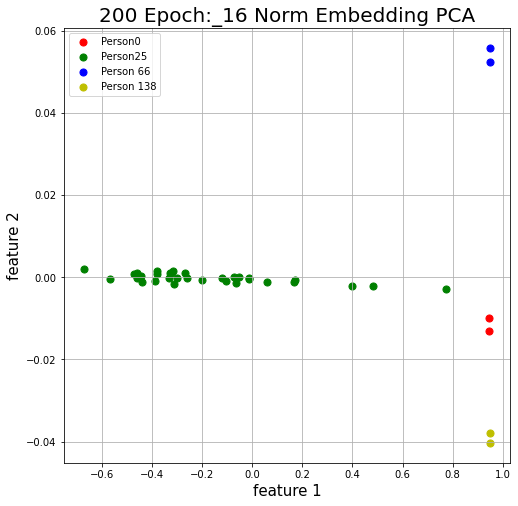

In [ ]:
#getting embedding from stored file
epochs = 800
num_f = 512
file_name = "/content/drive/MyDrive/Arcface/train_data_embeddings_"+str(epochs)+"model.npy"
norm_file_name = "/content/drive/MyDrive/Arcface/train_data_normalized_embeddings_"+str(epochs)+"model.npy"
embeddings = np.load(file_name)
norm_embeddings = np.load(norm_file_name)  

pca = PCA(n_components=2)

#getting image data, embeddings and normalized embeddings of 4 people
index = [None] * hypar.num_classes
ppl = [0,25,66,138]

for clas in ppl:
  index[clas] = []
  for i in range (0,X.shape[0]):
    if Y[i] == clas:
      index[clas].append(i)

ppl_emb = np.array(embeddings[index[ppl[0]][0]])
ppl_emb = np.reshape(ppl_emb,(1,num_f))
ppl_norm_emb = np.array(norm_embeddings[index[ppl[0]][0]])
ppl_norm_emb = np.reshape(ppl_norm_emb,(1,num_f))
ppl_targ = [ppl[0]]
print(ppl_emb.shape, ppl_norm_emb.shape)
for clas in ppl:
  l = []
  if clas==0:
    l = list(range(1,len(index[clas])-1))
  else:
    l = list(range(len(index[clas])))
  for i in l:
    j = index[clas][i]
    ppl_targ.append(clas)
    em = np.reshape(embeddings[j],(1,num_f))
    norm_em = np.reshape(norm_embeddings[j],(1,num_f))
    ppl_emb = np.concatenate((ppl_emb,em),axis=0)
    ppl_norm_emb = np.concatenate((ppl_norm_emb,norm_em),axis=0)

df = pd.DataFrame(ppl_targ,columns=["person"])
print(ppl_emb.shape, ppl_norm_emb.shape)


#embeddings PCA
principalComponents = pca.fit_transform(ppl_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title('200 Epoch:_16 Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#norm embeddings PCA
principalComponents = pca.fit_transform(ppl_norm_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title('200 Epoch:_16 Norm Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#TEST

#Importing Test data 
(Umic Members Images)

In [ ]:
X = np.load('/content/drive/MyDrive/Arcface/umic_members_images.npy', allow_pickle=True)
Y = np.load('/content/drive/MyDrive/Arcface/umic_members_Y.npy', allow_pickle=True)
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='int32')
Y = np.reshape(Y, Y.shape[0])
print("X shape:",X.shape,"Y shape:",Y.shape)
X = net.Resnet_preprocess(X)
print("Test data ready!")
open_file = open('/content/drive/MyDrive/Arcface/umic_members_names.pkl', "rb")
namelist = pickle.load(open_file)
open_file.close()
umic_test_num_classes = np.max(Y)+1

X shape: (28, 112, 112, 3) Y shape: (28,)
Test data ready!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


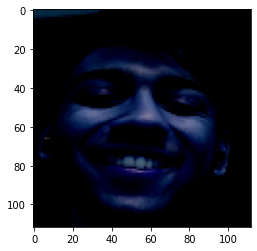

In [ ]:
index = 7
photo = cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB)
plt.imshow(photo/255)
plt.show()

#Getting embeddings

In [ ]:
#loading model
file_number = 800
file_name = '/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_'
file_name = file_name + str(file_number)+ '_epochs'
print(file_name)
model = tf.keras.models.load_model(file_name)

test_embeddings = get_embeddings(X,model)
test_embeddings = np.asarray(test_embeddings)
print(test_embeddings.shape)
np.save('/content/drive/MyDrive/Arcface/umic_members_800_embedding_database.npy', test_embeddings)

/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_800_epochs
(28, 512)
(28, 512)


In [ ]:
print(np.max(Y))

9


In [ ]:
def umic_calculate_threshold(X,Y,model,nor,epochs):
  index = [None] * X.shape[0]

  #getting and storing embeddings
  embeddings = get_embeddings(X,model)
  file_name = "/content/drive/MyDrive/Arcface/umic_data_embeddings_"+str(epochs)+"model.npy"
  if nor==True:
    embeddings = normalize(embeddings, axis = 0)
    file_name = "/content/drive/MyDrive/Arcface/umic_data_normalized_embeddings_"+str(epochs)+"model.npy"
  emb = np.array(embeddings)
  np.save(file_name,emb)

  same_person_distance = []
  same_person_cosine_distance = []
  same_person_euclidean_distance = []
  for clas in range(umic_test_num_classes):
    index[clas] = []
    for i in range (0,X.shape[0]):
      if Y[i] == clas:
        index[clas].append(i)
    for i in range(len(index[clas])):
      i1=index[clas][i]
      for j in range(i+1,len(index[clas])):
        j2=index[clas][j]
        distance,cosine_distance,euclidean_distance = get_distance(embeddings[i1],embeddings[j2])
        same_person_distance.append(distance)
        same_person_cosine_distance.append(cosine_distance)
        same_person_euclidean_distance.append(euclidean_distance)

  same_person_distance = np.asarray(same_person_distance)
  same_person_cosine_distance = np.asarray(same_person_cosine_distance)
  same_person_euclidean_distance = np.asarray(same_person_euclidean_distance)

  #saving same person distances
  f1 = "/content/drive/MyDrive/Arcface/umic_same_person_distance_"+str(epochs)+"model.npy"
  f2 = "/content/drive/MyDrive/Arcface/umic_same_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "/content/drive/MyDrive/Arcface/umic_same_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,same_person_distance)
  np.save(f2,same_person_cosine_distance)
  np.save(f3,same_person_euclidean_distance)
  
  same_person_distance_mean = np.mean(same_person_distance)
  same_person_cosine_distance_mean = np.mean(same_person_cosine_distance)
  same_person_euclidean_distance_mean = np.mean(same_person_euclidean_distance)

  diff_person_distance = []
  diff_person_cosine_distance = []
  diff_person_euclidean_distance = []
  for clas in range(umic_test_num_classes):
      for c in range(clas+1,umic_test_num_classes):
          for i in range(len(index[clas])):
              for j in range(len(index[c])):
                  distance,cosine_distance,euclidean_distance = get_distance(embeddings[index[clas][i]],embeddings[index[c][j]])
                  diff_person_distance.append(distance)
                  diff_person_cosine_distance.append(cosine_distance)

                  diff_person_euclidean_distance.append(euclidean_distance)

  diff_person_distance = np.asarray(diff_person_distance)
  diff_person_cosine_distance = np.asarray(diff_person_cosine_distance)
  diff_person_euclidean_distance = np.asarray(diff_person_euclidean_distance)

  #saving different person distances
  f1 = "/content/drive/MyDrive/Arcface/umic_diff_person_distance_"+str(epochs)+"model.npy"
  f2 = "/content/drive/MyDrive/Arcface/umic_diff_person_cosine_distance_"+str(epochs)+"model.npy"
  f3 = "/content/drive/MyDrive/Arcface/umic_diff_person_euclidean_distance_"+str(epochs)+"model.npy"
  if nor==True:
    f1 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_distance_"+str(epochs)+"model.npy"
    f2 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
    f3 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"
  np.save(f1,diff_person_distance)
  np.save(f2,diff_person_cosine_distance)
  np.save(f3,diff_person_euclidean_distance)

  diff_person_distance_mean = np.mean(diff_person_distance)
  diff_person_cosine_distance_mean = np.mean(diff_person_cosine_distance)
  diff_person_euclidean_distance_mean = np.mean(diff_person_euclidean_distance)

  alpha=0.8
  distance_threshold = diff_person_distance_mean*(1-alpha)+same_person_distance_mean*alpha
  cosine_distance_threshold = diff_person_cosine_distance_mean*(1-alpha)+same_person_cosine_distance_mean*alpha
  euclidean_distance_threshold = diff_person_euclidean_distance_mean*(1-alpha)+same_person_euclidean_distance_mean*alpha
  return distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean

##Getting Distance and Thresholds

In [ ]:
d_threshold= []
cd_threshold = []
ed_threshold = []
d_norm_threshold= []
cd_norm_threshold = []
ed_norm_threshold = []
for file_number in [800]:
  #loading model
  file_name = '/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_'
  file_name = file_name + str(file_number)+ '_epochs'
  print(file_name)
  model = tf.keras.models.load_model(file_name)

  #non-normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = umic_calculate_threshold(X,Y,model,False,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_threshold.append(distance_threshold)
  cd_threshold.append(cosine_distance_threshold)
  ed_threshold.append(euclidean_distance_threshold)

  #normalized
  distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean = umic_calculate_threshold(X,Y,model,True,file_number)
  print(distance_threshold, cosine_distance_threshold, euclidean_distance_threshold, same_person_distance_mean, same_person_cosine_distance_mean, same_person_euclidean_distance_mean, diff_person_distance_mean, diff_person_cosine_distance_mean, diff_person_euclidean_distance_mean)
  d_norm_threshold.append(distance_threshold)
  cd_norm_threshold.append(cosine_distance_threshold)
  ed_norm_threshold.append(euclidean_distance_threshold)

/content/drive/MyDrive/Arcface/checkpoint/try3/model_weights_800_epochs
(28, 512)
1502.7189453125 0.6718809610829591 75.5189453125 1614.4956 0.6469948242884129 73.10826 1055.6123 0.7714255082611441 85.16168
(28, 512)
4.7296462059021 0.7313614159576848 4.9401219367980955 5.182284 0.7054709308431484 4.8023143 2.9190955 0.8349233564158304 5.4913526


##Distance Scatterplots

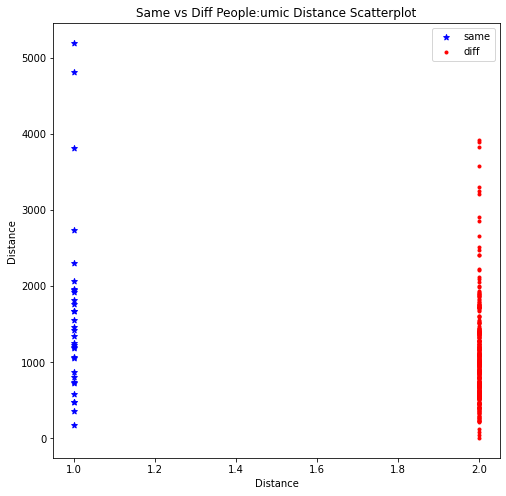

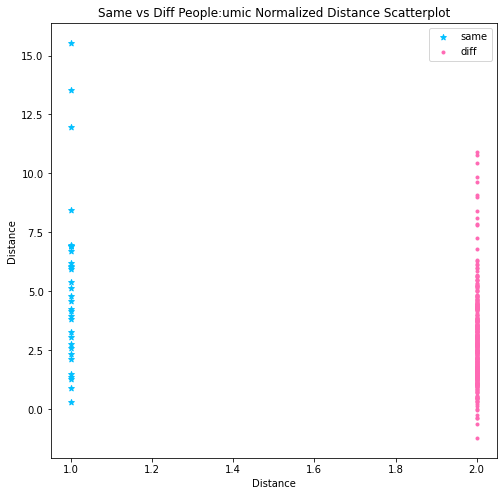

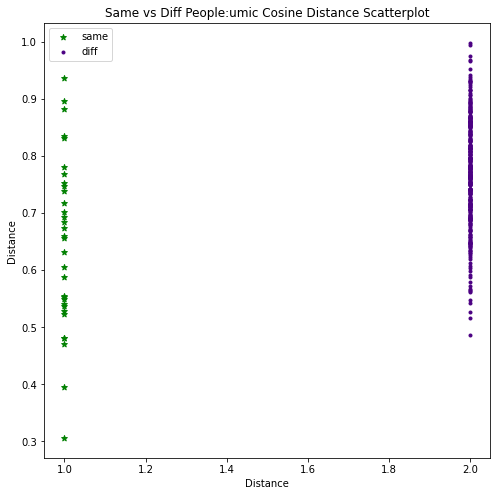

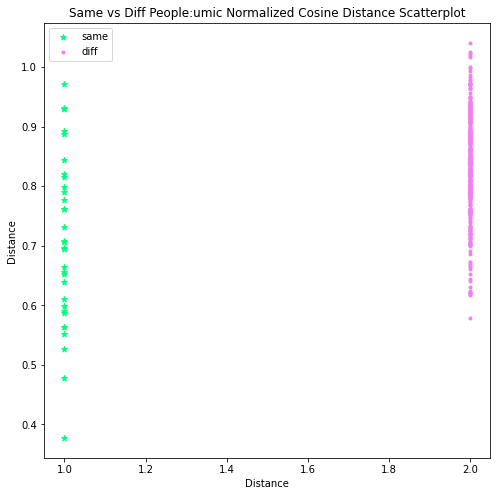

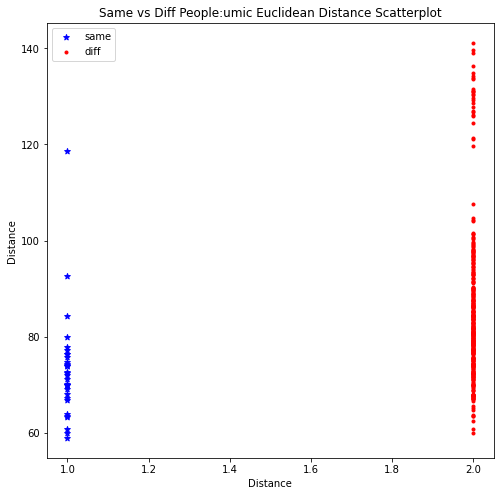

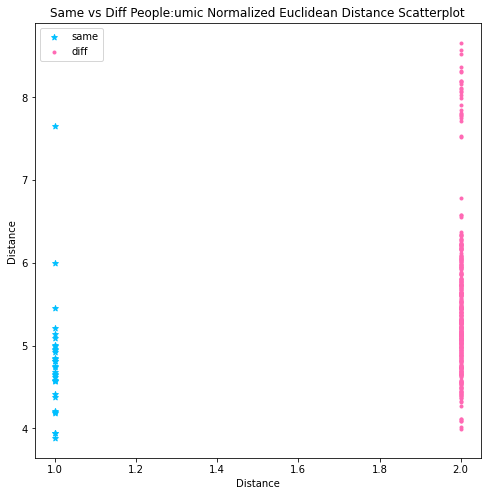

In [ ]:
epochs = 800

#loading data
f1 = "/content/drive/MyDrive/Arcface/umic_same_person_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/umic_same_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/umic_same_person_euclidean_distance_"+str(epochs)+"model.npy"

same_person_distance = np.load(f1)
same_person_cosine_distance = np.load(f2)
same_person_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/umic_same_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

same_person_norm_distance = np.load(f1)
same_person_norm_cosine_distance = np.load(f2)
same_person_norm_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/umic_diff_person_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/umic_diff_person_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/umic_diff_person_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_distance = np.load(f1)
diff_person_cosine_distance = np.load(f2)
diff_person_euclidean_distance = np.load(f3)

f1 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_distance_"+str(epochs)+"model.npy"
f2 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_cosine_distance_"+str(epochs)+"model.npy"
f3 = "/content/drive/MyDrive/Arcface/umic_diff_person_normalized_euclidean_distance_"+str(epochs)+"model.npy"

diff_person_norm_distance = np.load(f1)
diff_person_norm_cosine_distance = np.load(f2)
diff_person_norm_euclidean_distance = np.load(f3)

#_____Creating scatter plots (same vs diff)_______
def scatter_plot(same,diff,title,color1,color2):
  plt.figure(figsize = (8,8))
  al = np.ones((len(same)))
  al2 = np.ones((len(diff)))
  plt.scatter(al, same, color=color1, marker="*")
  plt.scatter(2*al2, diff, color=color2, marker=".")
  plt.xlabel("Distance")
  plt.ylabel("Distance")
  plt.legend(["same","diff"])
  plt.title(title)
  plt.show()

#distance data
scatter_plot(same_person_distance, diff_person_distance, "Same vs Diff People:umic Distance Scatterplot", "blue", "red")

#normailzed distance data
scatter_plot(same_person_norm_distance,diff_person_norm_distance,"Same vs Diff People:umic Normalized Distance Scatterplot", "deepskyblue", "hotpink")

#cosine distance data
scatter_plot(same_person_cosine_distance, diff_person_cosine_distance, "Same vs Diff People:umic Cosine Distance Scatterplot", "green", "indigo")

#cosine normailzed distance data
scatter_plot(same_person_norm_cosine_distance, diff_person_norm_cosine_distance, "Same vs Diff People:umic Normalized Cosine Distance Scatterplot", "springgreen", "violet")

#euclidean distance data
scatter_plot(same_person_euclidean_distance, diff_person_euclidean_distance, "Same vs Diff People:umic Euclidean Distance Scatterplot", "blue", "red")

#euclidean normailzed distance data
scatter_plot(same_person_norm_euclidean_distance, diff_person_norm_euclidean_distance, "Same vs Diff People:umic Normalized Euclidean Distance Scatterplot", "deepskyblue", "hotpink")

##Test PCA

(1, 512) (1, 512)
(11, 512) (11, 512)


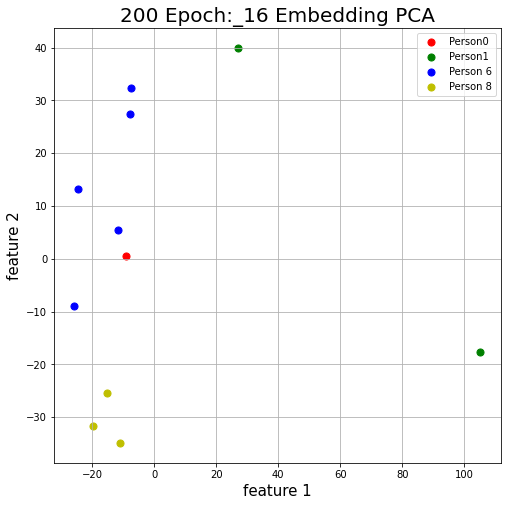

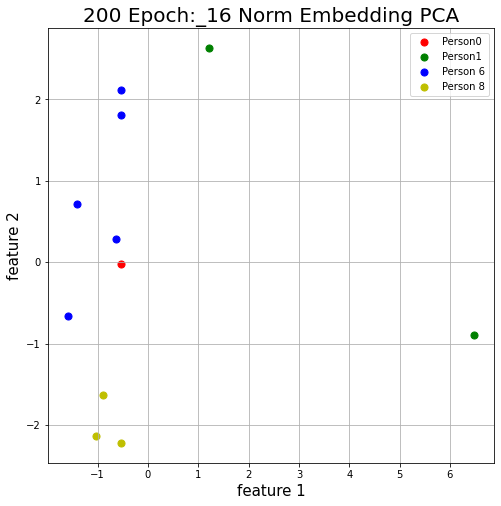

In [ ]:
#getting embedding from stored file
epochs = 800
num_f = 512
file_name = "/content/drive/MyDrive/Arcface/umic_data_embeddings_"+str(epochs)+"model.npy"
norm_file_name = "/content/drive/MyDrive/Arcface/umic_data_normalized_embeddings_"+str(epochs)+"model.npy"
embeddings = np.load(file_name)
norm_embeddings = np.load(norm_file_name)  

pca = PCA(n_components=2)

#getting image data, embeddings and normalized embeddings of 4 people
index = [None] * hypar.num_classes
ppl = [0,1,6,8]

for clas in ppl:
  index[clas] = []
  for i in range (0,X.shape[0]):
    if Y[i] == clas:
      index[clas].append(i)

ppl_emb = np.array(embeddings[index[ppl[0]][0]])
ppl_emb = np.reshape(ppl_emb,(1,num_f))
ppl_norm_emb = np.array(norm_embeddings[index[ppl[0]][0]])
ppl_norm_emb = np.reshape(ppl_norm_emb,(1,num_f))
ppl_targ = [ppl[0]]
print(ppl_emb.shape, ppl_norm_emb.shape)
for clas in ppl:
  l = []
  if clas==0:
    l = list(range(1,len(index[clas])-1))
  else:
    l = list(range(len(index[clas])))
  for i in l:
    j = index[clas][i]
    ppl_targ.append(clas)
    em = np.reshape(embeddings[j],(1,num_f))
    norm_em = np.reshape(norm_embeddings[j],(1,num_f))
    ppl_emb = np.concatenate((ppl_emb,em),axis=0)
    ppl_norm_emb = np.concatenate((ppl_norm_emb,norm_em),axis=0)

df = pd.DataFrame(ppl_targ,columns=["person"])
print(ppl_emb.shape, ppl_norm_emb.shape)


#embeddings PCA
principalComponents = pca.fit_transform(ppl_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title('200 Epoch:_16 Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#norm embeddings PCA
principalComponents = pca.fit_transform(ppl_norm_emb)
principalDf = pd.DataFrame(data = principalComponents , columns = ['feature 1', 'feature 2'])
principalDf.head(5)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('feature 1', fontsize = 15)
ax.set_ylabel('feature 2', fontsize = 15)
ax.set_title('200 Epoch:_16 Norm Embedding PCA', fontsize = 20)

finalDf = pd.concat([principalDf, df['person']], axis = 1)

targets = ["Person"+str(ppl[0]),"Person"+str(ppl[1]),"Person "+str(ppl[2]),"Person "+str(ppl[3])]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(ppl,colors):
    indicesToKeep = finalDf['person'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'feature 1']
               , finalDf.loc[indicesToKeep, 'feature 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()